# Match Report

## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from bs4 import BeautifulSoup
import json
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import highlight_text
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from mplsoccer import Pitch, VerticalPitch
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
from matplotlib.patches import Rectangle
import matplotlib.font_manager as font_manager
import soccerdata as sd
from matplotlib.lines import Line2D
import soccerdata as sd
from matplotlib.colors import to_rgba

pd.set_option("display.max_rows", None, "display.max_columns", None)
background = "black"
text_color = 'w'
primary = '#C8102E'
secondary = 'lightblue'
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

[06/15/24 12:50:00] INFO     No custom team name replacements found. You can configure these in       ]8;id=105403;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=691468;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_config.py#87\87]8;;\
                             C:\Users\acer\soccerdata\config\teamname_replacements.json.                           

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=458919;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=807594;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_config.py#177\177]8;;\
                             C:\Users\acer\soccerdata\config\league_dict.json.                                     

## Calling Understat with desired Match ID

In [2]:
#scrape a single game shots. We will allow users to enter a base url
base_url = 'https://understat.com/match/'
match = str(input('Please enter the match id: '))
url = base_url+match

Please enter the match id:  22233


## Function to scrape data from website as json

In [3]:
def scrape_understat(url):
    res = requests.get(url)
    soup = BeautifulSoup(res.content, "lxml")
    scripts = soup.find_all('script')
    
    string_with_json_obj = '' 
    # Find data for teams 
    for el in scripts: 
        if 'shotsData' in el.text: 
            string_with_json_obj = el.text.strip()
    #print(string_with_json_obj)
    
    # strip unnecessary symbols and get only JSON data 
    ind_start = string_with_json_obj.index("('")+2 
    ind_end = string_with_json_obj.index("')") 
    json_data = string_with_json_obj[ind_start:ind_end] 
    json_data = json_data.encode('utf8').decode('unicode_escape')
    
    #convert string to json format
    data = json.loads(json_data)
    return data


data = scrape_understat(url)

## Creating pandas df with scraped json

In [4]:
def create_df(data):
    x = []
    y = []
    xG = []
    result = []
    team = []
    player = []
    minute = []
    situation = []
    player_assisted = []
    data_away = data['a']
    data_home = data['h']
    
    for index in range(len(data_home)):
        for key in data_home[index]:
            if key == 'X':
                x.append(data_home[index][key])
            if key == 'Y':
                y.append(data_home[index][key])
            if key == 'h_team':
                team.append(data_home[index][key])
            if key == 'xG':
                xG.append(data_home[index][key])
            if key == 'result':
                result.append(data_home[index][key])
            if key == 'player':
                player.append(data_home[index][key])
            if key == 'minute':
                minute.append(data_home[index][key])
            if key == 'situation':
                situation.append(data_home[index][key])
            if key == 'player_assisted':
                player_assisted.append(data_home[index][key])
    
    for index in range(len(data_away)):
        for key in data_away[index]:
            if key == 'X':
                x.append(data_away[index][key])
            if key == 'Y':
                y.append(data_away[index][key])
            if key == 'a_team':
                team.append(data_away[index][key])
            if key == 'xG':
                xG.append(data_away[index][key])
            if key == 'result':
                result.append(data_away[index][key])
            if key == 'player':
                player.append(data_away[index][key])
            if key == 'minute':
                minute.append(data_away[index][key])
            if key == 'situation':
                situation.append(data_away[index][key])
            if key == 'player_assisted':
                player_assisted.append(data_away[index][key])

    col_names = ['x','y','xG','result','team','player','minute','situation','player_assisted']
    df = pd.DataFrame([x,y,xG,result,team,player,minute,situation,player_assisted],index=col_names)
    df = df.T
    df['x'] = pd.to_numeric(df['x'])
    df['y'] = pd.to_numeric(df['y'])
    df['xG'] = pd.to_numeric(df['xG'])
    df['minute'] = pd.to_numeric(df['minute'])
    
    df['x'] = df['x']*100
    df['y'] = df['y']*100
    
    df['xx'] = df['y']
    df['yy'] = df['x']
    
    df['x'] = df['xx']
    df['y'] = df['yy']
    
    df['x'] = df['x']*.8
    df['y'] = df['y']*1.2

    return df

df = create_df(data)

## Calculate Total xG Created by both Teams

In [5]:
hteam = df['team'].iloc[0]
ateam = df['team'].iloc[-1]
a_xG = [0]
h_xG = [0]
a_min = [0]
h_min = [0]

for x in range(len(df['xG'])):
    if df['team'][x] == ateam:
        a_xG.append(df['xG'][x])
        a_min.append(df['minute'][x])
    if df['team'][x] == hteam:
        h_xG.append(df['xG'][x])
        h_min.append(df['minute'][x])
    
def nums_cumulative_sum(nums_list):
  return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

acum = nums_cumulative_sum(a_xG)
hcum = nums_cumulative_sum(h_xG)
alast = round(acum[-1],2)
hlast = round(hcum[-1],2)

print(f"Total xG created by {ateam}: {alast}")
print(f"Total xG created by {hteam}: {hlast}")

Total xG created by Manchester City: 2.7
Total xG created by Tottenham: 1.84


## Calculate Total Shots and Total Shots On Target Taken by both Teams

In [6]:
def calculateTotalShotsByTeam(team):
    total_shots = 0
    total_shots_on_target = 0
    for x in range(len(df['x'])):
        if df['team'][x] == team:
            if df['result'][x] == 'SavedShot' or df['result'][x] == 'Goal':
                total_shots += 1
                total_shots_on_target +=1
            else:
                total_shots += 1
    return total_shots,total_shots_on_target

# Example usage:
ateam_total_shots,ateam_total_shots_on_target = calculateTotalShotsByTeam(ateam)  # Replace 'ateam' with the desired team name
hteam_total_shots,hteam_total_shots_on_target = calculateTotalShotsByTeam(hteam)  # Replace 'hteam' with the desired team name

print(f"Total shots by {ateam}: {ateam_total_shots}")
print(f"Total shots on target by {ateam}: {ateam_total_shots_on_target}")
print(f"Total shots by {hteam}: {hteam_total_shots}")
print(f"Total shots on target by {hteam}: {hteam_total_shots_on_target}")

Total shots by Manchester City: 8
Total shots on target by Manchester City: 5
Total shots by Tottenham: 10
Total shots on target by Tottenham: 5


## Calculating Goals Scored by each team

In [7]:
def calculateTotalGoalsByTeam(hteam,ateam):
    total_goals_hteam = 0
    total_goals_ateam = 0
    for x in range(len(df['x'])):
        if df['team'][x] == hteam:
            if df['result'][x] == 'Goal':
                total_goals_hteam += 1
            if df['result'][x] == 'OwnGoal':  
                total_goals_ateam +=1
        if df['team'][x] == ateam:
            if df['result'][x] == 'Goal':
                total_goals_ateam += 1
            if df['result'][x] == 'OwnGoal':  
                total_goals_hteam +=1
    return total_goals_hteam,total_goals_ateam


hteam_total_goals , ateam_total_goals = calculateTotalGoalsByTeam(hteam,ateam)  # Replace 'hteam' with the desired team name

print(f"Total goals by {ateam}: {ateam_total_goals}")
print(f"Total goals by {hteam}: {hteam_total_goals}")

Total goals by Manchester City: 2
Total goals by Tottenham: 0


## Using Soccerdata lib to extract Stats from FotMob

In [9]:
ateam = 'Manchester City'
hteam = 'Tottenham Hotspur'
fotmob = sd.FotMob(leagues='ENG-Premier League', seasons='2023/2024')
match_stats_hteam = fotmob.read_team_match_stats(opponent_stats=False, team=hteam,stat_type='Top stats')
match_stats_ateam = fotmob.read_team_match_stats(opponent_stats=False, team=ateam,stat_type='Top stats')

[05/15/24 13:19:39] INFO     Saving cached data to C:\Users\acer\soccerdata\data\FotMob               ]8;id=117502;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=999285;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_common.py#91\91]8;;\

[05/15/24 13:19:42] INFO     [1/37] Retrieving game with id=4193457                                   ]8;id=840112;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=744110;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:43] INFO     [2/37] Retrieving game with id=4193477                                   ]8;id=842639;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=89757;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [3/37] Retrieving game with id=4193480                                   ]8;id=670538;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=155148;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:44] INFO     [4/37] Retrieving game with id=4193493                                   ]8;id=673315;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=699045;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:45] INFO     [5/37] Retrieving game with id=4193507                                   ]8;id=618574;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=517549;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [6/37] Retrieving game with id=4193510                                   ]8;id=351325;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=728304;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:46] INFO     [7/37] Retrieving game with id=4193527                                   ]8;id=94392;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=385191;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:47] INFO     [8/37] Retrieving game with id=4193536                                   ]8;id=543750;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=925023;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [9/37] Retrieving game with id=4193549                                   ]8;id=403572;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=600590;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [10/37] Retrieving game with id=4193555                                  ]8;id=232134;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=591615;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:48] INFO     [11/37] Retrieving game with id=4193569                                  ]8;id=994195;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=895780;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [12/37] Retrieving game with id=4193579                                  ]8;id=851346;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=415008;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [13/37] Retrieving game with id=4193660                                  ]8;id=937452;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=424710;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [14/37] Retrieving game with id=4193667                                  ]8;id=642687;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=181744;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:49] INFO     [15/37] Retrieving game with id=4193677                                  ]8;id=655071;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=331812;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:50] INFO     [16/37] Retrieving game with id=4193689                                  ]8;id=84264;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=663199;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [17/37] Retrieving game with id=4193699                                  ]8;id=249946;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=770445;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:51] INFO     [18/37] Retrieving game with id=4193708                                  ]8;id=395593;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=474721;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:52] INFO     [19/37] Retrieving game with id=4193714                                  ]8;id=21831;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=638127;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:53] INFO     [20/37] Retrieving game with id=4193728                                  ]8;id=940599;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=263967;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:54] INFO     [21/37] Retrieving game with id=4193738                                  ]8;id=182453;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=100743;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:55] INFO     [22/37] Retrieving game with id=4193745                                  ]8;id=967372;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=812816;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [23/37] Retrieving game with id=4193757                                  ]8;id=222921;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=250200;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:56] INFO     [24/37] Retrieving game with id=4193768                                  ]8;id=830276;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=882714;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [25/37] Retrieving game with id=4193780                                  ]8;id=870829;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=269974;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [26/37] Retrieving game with id=4193800                                  ]8;id=540994;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=274192;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [27/37] Retrieving game with id=4193803                                  ]8;id=971901;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=335065;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [28/37] Retrieving game with id=4193816                                  ]8;id=703384;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=338378;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [29/37] Retrieving game with id=4193830                                  ]8;id=159377;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=218448;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [30/37] Retrieving game with id=4193836                                  ]8;id=952500;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=935580;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:57] INFO     [31/37] Retrieving game with id=4193849                                  ]8;id=829440;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=790859;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [32/37] Retrieving game with id=4193858                                  ]8;id=809768;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=586966;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:19:59] INFO     [33/37] Retrieving game with id=4193878                                  ]8;id=903008;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=401340;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:20:00] INFO     [34/37] Retrieving game with id=4193785                                  ]8;id=302199;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=572689;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:20:01] INFO     [35/37] Retrieving game with id=4193887                                  ]8;id=328184;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=357070;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:20:02] INFO     [36/37] Retrieving game with id=4193898                                  ]8;id=314844;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=482237;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [37/37] Retrieving game with id=4193869                                  ]8;id=435722;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=216487;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:20:04] INFO     [1/37] Retrieving game with id=4193450                                   ]8;id=26313;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=68041;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [2/37] Retrieving game with id=4193475                                   ]8;id=548142;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=968620;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [3/37] Retrieving game with id=4193489                                   ]8;id=825775;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=771275;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:20:05] INFO     [4/37] Retrieving game with id=4193498                                   ]8;id=382176;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=271270;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [5/37] Retrieving game with id=4193508                                   ]8;id=70223;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=934082;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [6/37] Retrieving game with id=4193518                                   ]8;id=217048;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=73648;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [7/37] Retrieving game with id=4193529                                   ]8;id=632231;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=661992;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [8/37] Retrieving game with id=4193530                                   ]8;id=73105;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=878031;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [9/37] Retrieving game with id=4193545                                   ]8;id=124773;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=415662;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [10/37] Retrieving game with id=4193557                                  ]8;id=667205;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=394093;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [11/37] Retrieving game with id=4193565                                  ]8;id=335800;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=323101;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [12/37] Retrieving game with id=4193574                                  ]8;id=636071;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=318277;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [13/37] Retrieving game with id=4193656                                  ]8;id=941270;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=129967;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [14/37] Retrieving game with id=4193667                                  ]8;id=431211;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=361672;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [15/37] Retrieving game with id=4193671                                  ]8;id=212428;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=538450;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [16/37] Retrieving game with id=4193686                                  ]8;id=991522;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=780690;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [17/37] Retrieving game with id=4193697                                  ]8;id=391883;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=933466;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [18/37] Retrieving game with id=4193717                                  ]8;id=404580;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=557060;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [19/37] Retrieving game with id=4193726                                  ]8;id=443689;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=41044;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

[05/15/24 13:20:06] INFO     [20/37] Retrieving game with id=4193739                                  ]8;id=348698;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=185169;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [21/37] Retrieving game with id=4193750                                  ]8;id=659774;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=753334;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [22/37] Retrieving game with id=4193753                                  ]8;id=382485;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=926689;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [23/37] Retrieving game with id=4193766                                  ]8;id=864642;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=664079;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [24/37] Retrieving game with id=4193776                                  ]8;id=27678;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=754435;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [25/37] Retrieving game with id=4193706                                  ]8;id=993420;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=237908;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [26/37] Retrieving game with id=4193781                                  ]8;id=679806;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=247094;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [27/37] Retrieving game with id=4193796                                  ]8;id=296833;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=290690;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [28/37] Retrieving game with id=4193807                                  ]8;id=189189;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=285951;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [29/37] Retrieving game with id=4193826                                  ]8;id=754928;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=151204;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [30/37] Retrieving game with id=4193840                                  ]8;id=166722;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=747804;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [31/37] Retrieving game with id=4193843                                  ]8;id=735150;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=85285;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [32/37] Retrieving game with id=4193857                                  ]8;id=755266;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=900325;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [33/37] Retrieving game with id=4193812                                  ]8;id=509322;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=388827;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [34/37] Retrieving game with id=4193877                                  ]8;id=637037;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=907745;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [35/37] Retrieving game with id=4193889                                  ]8;id=373845;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=632828;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [36/37] Retrieving game with id=4193894                                  ]8;id=901756;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=757062;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

                    INFO     [37/37] Retrieving game with id=4193869                                  ]8;id=173519;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py\fotmob.py]8;;\:]8;id=758720;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\fotmob.py#398\398]8;;\

In [11]:
match_stats_ateam

Accurate passes  \
league             season game                                               team                              
ENG-Premier League 2324   2023-08-11 Burnley-Manchester City                 Manchester City             634   
                          2023-08-19 Manchester City-Newcastle United        Manchester City             611   
                          2023-08-27 Sheffield United-Manchester City        Manchester City             685   
                          2023-09-02 Manchester City-Fulham                  Manchester City             656   
                          2023-09-16 West Ham United-Manchester City         Manchester City             653   
                          2023-09-23 Manchester City-Nottingham Forest       Manchester City             509   
                          2023-09-30 Wolverhampton Wanderers-Manchester City Manchester City             526   
                          2023-10-08 Arsenal-Manchester City                 Manchester City             451   
                          2023-10-21 Manchester City-Brighton & Hove Albion  Manchester City             546   
                          2023-10-29 Manchester United-Manchester City       Manchester City             542   
                          2023-11-04 Manchester City-AFC Bournemouth         Manchester City             680   
                          2023-11-12 Chelsea-Manchester City                 Manchester City             477   
                          2023-11-25 Manchester City-Liverpool               Manchester City             559   
                          2023-12-03 Manchester City-Tottenham Hotspur       Manchester City             501   
                          2023-12-06 Aston Villa-Manchester City             Manchester City             454   
                          2023-12-10 Luton Town-Manchester City              Manchester City             513   
                          2023-12-16 Manchester City-Crystal Palace          Manchester City             751   
                          2023-12-27 Everton-Manchester City                 Manchester City             701   
                          2023-12-30 Manchester City-Sheffield United        Manchester City             944   
                          2024-01-13 Newcastle United-Manchester City        Manchester City             677   
                          2024-01-31 Manchester City-Burnley                 Manchester City             717   
                          2024-02-05 Brentford-Manchester City               Manchester City             679   
                          2024-02-10 Manchester City-Everton                 Manchester City             709   
                          2024-02-17 Manchester City-Chelsea                 Manchester City             647   
                          2024-02-20 Manchester City-Brentford               Manchester City             656   
                          2024-02-24 AFC Bournemouth-Manchester City         Manchester City             493   
                          2024-03-03 Manchester City-Manchester United       Manchester City             736   
                          2024-03-10 Liverpool-Manchester City               Manchester City             435   
                          2024-03-31 Manchester City-Arsenal                 Manchester City             618   
                          2024-04-03 Manchester City-Aston Villa             Manchester City             647   
                          2024-04-06 Crystal Palace-Manchester City          Manchester City             772   
                          2024-04-13 Manchester City-Luton Town              Manchester City             704   
                          2024-04-25 Brighton & Hove Albion-Manchester City  Manchester City             734   
                          2024-04-28 Nottingham Forest-Manchester City       Manchester City             665   
                          2024-05-04 Manchester City-Wolverha

In [12]:
#### Stats extracted from FotMob dataframes - done manually as of now, need to find a better method

possesion_hteam = 53
possesion_ateam = 47
big_chances_ateam = 4
big_chances_hteam = 4
accurate_passes_per_hteam = 89
accurate_passes_per_ateam = 89

## Creating Plot for Overall Stats

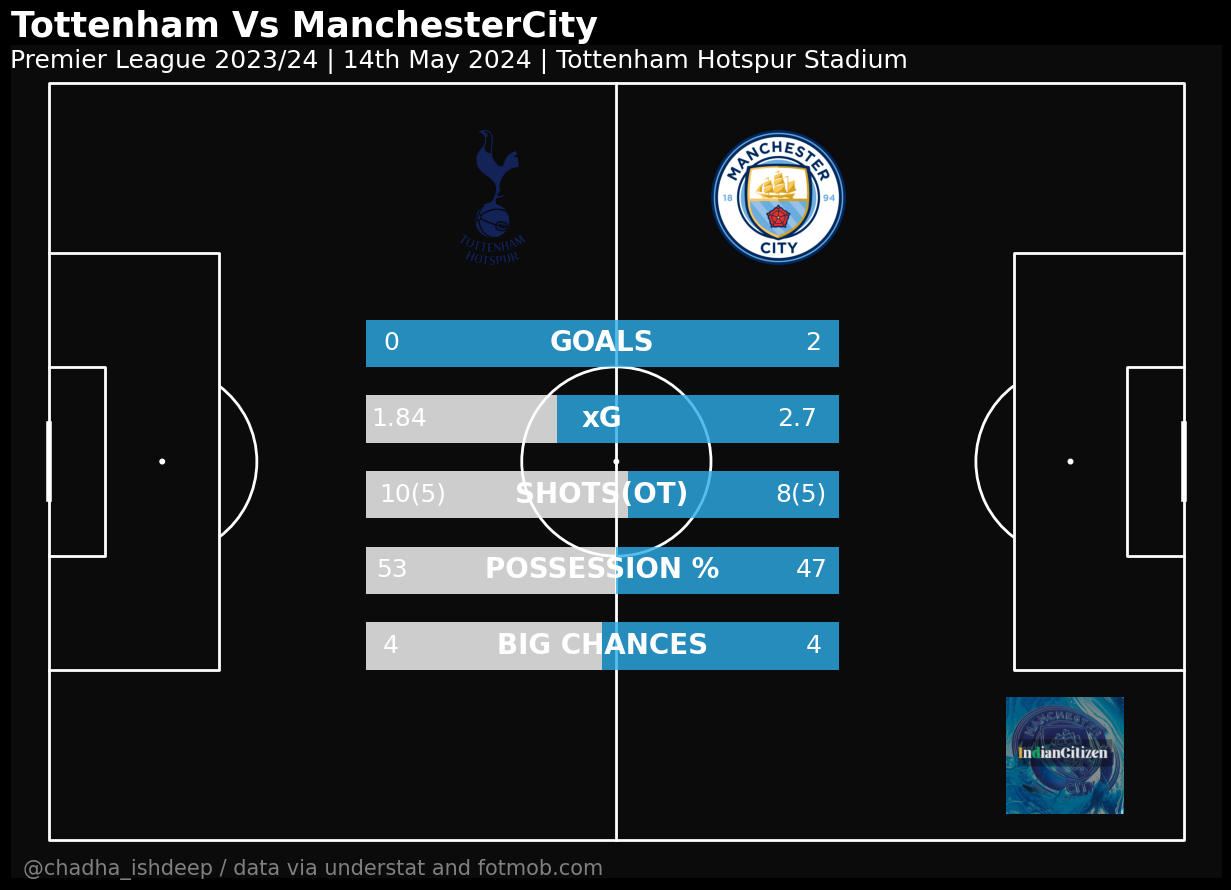

In [20]:
pitch = Pitch(pitch_color='black', line_color='white',
              stripe=False)  # optional stripes
fig, ax = pitch.draw(figsize=(13,9))
fig.set_facecolor('black')
ax.patch.set_facecolor('#0B0B0B')

hteam = 'Tottenham'
ateam = 'ManchesterCity'

img_hteam = mpimg.imread(f'C:/Users/acer/Desktop/IndianCityzen/Projects/Images/TeamLogos/{hteam}.png')
img_ateam = mpimg.imread(f'C:/Users/acer/Desktop/IndianCityzen/Projects/Images/TeamLogos/{ateam}.png')
logo = mpimg.imread('C:/Users/acer/Desktop/IndianCityzen/Projects/Images/Logo.png')


ax_image = add_image(
    img_hteam, fig, left=0.33, bottom=0.7, width=0.15, height=0.15,aspect='equal'
)

ax_image = add_image(
    img_ateam, fig, left=0.55, bottom=0.7, width=0.15, height=0.15,aspect='equal'
)

ax_image = add_image(
    logo, fig, left=0.78, bottom=0.09, width=0.13, height=0.13,alpha=0.9,aspect='equal'
)


# Set title
ax.set_title(f'{hteam} Vs {ateam}',fontdict={'fontsize': 25, 'weight': 'bold', 'color': 'white'}, loc='left')
# Add subtitle
subtitle_text = "Premier League 2023/24 | 14th May 2024 | Tottenham Hotspur Stadium"
ax.text(0.37, 0.98, subtitle_text, ha='center', va='center', transform=ax.transAxes, color='white', fontsize=18)

##### Adding Goals

goals_hteam = hteam_total_goals
goals_ateam = ateam_total_goals

# Calculate the width of the rectangle for each team
total_goals = goals_hteam + goals_ateam

# Define the minimum width for the rectangles
min_rect_width = 9

#width_hteam = goals_hteam / total_goals
#width_ateam = goals_ateam / total_goals

# Coordinates for the rectangle
rect_x = 33.5 # X-coordinate of the left side of the rectangle
rect_y = 25  # Y-coordinate of the top side of the rectangle
rect_width = 50  # Width of the rectangle
rect_height = 5  # Height of the rectangle

# Calculate the width of the rectangle for each team
# Calculate the width of the rectangle for each team
if goals_hteam == 0 and goals_ateam > 0:
    # If the home team scored 0 goals and the away team scored greater than 0
    width_hteam = 0
    width_ateam = 1
elif goals_hteam > 0 and goals_ateam == 0:
    # If the away team scored 0 goals and the home team scored greater than 0
    width_hteam = 1
    width_ateam = 0
elif total_goals > 0:
    # If both teams scored some goals
    width_hteam = max(goals_hteam / total_goals, min_rect_width / rect_width)
    width_ateam = max(goals_ateam / total_goals, min_rect_width / rect_width)
else:
    # Both teams scored 0 goals, set equal width for both
    width_hteam = min_rect_width / rect_width
    width_ateam = min_rect_width / rect_width


ateam_facecolor = '#2CAEEA'
hteam_facecolor = '#FFFFFF'

# Create a rectangle patch for hteam
rect_hteam = Rectangle((rect_x, rect_y), width_hteam * rect_width, rect_height, facecolor=hteam_facecolor,alpha=0.8)

# Create a rectangle patch for ateam
rect_ateam = Rectangle((rect_x + width_hteam * rect_width, rect_y), width_ateam * rect_width, rect_height, facecolor=ateam_facecolor,alpha=0.8)

# Add rectangles to the pitch
ax.add_patch(rect_hteam)
ax.add_patch(rect_ateam)

# Calculate the position for 'GOALS' text
goals_text_x = rect_x + width_hteam * rect_width + (width_ateam * rect_width - width_hteam * rect_width) / 2
goals_text_y = rect_y + rect_height / 2

# Add labels for teams' goals
ax.text(37, rect_y + rect_height / 2, str(goals_hteam), color='white', ha='right', va='center',fontsize=18)
ax.text(goals_text_x, goals_text_y, 'GOALS', color='white', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
ax.text(80, rect_y + rect_height / 2, str(goals_ateam), color='white', ha='left', va='center',fontsize=18)



#### Adding xG
xG_hteam = hlast
xG_ateam = alast

# Calculate the width of the rectangle for each team
total_xG = xG_hteam + xG_ateam
width_hteam_xG = xG_hteam / total_xG
width_ateam_xG = xG_ateam / total_xG

# Coordinates for the rectangle
xG_rect_x = 33.5 # X-coordinate of the left side of the rectangle
xG_rect_y = 33 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for hteam
xG_rect_hteam = Rectangle((xG_rect_x, xG_rect_y), width_hteam_xG * rect_width, rect_height, facecolor=hteam_facecolor,alpha=0.8)

# Create a rectangle patch for ateam
xG_rect_ateam = Rectangle((xG_rect_x + width_hteam_xG * rect_width, xG_rect_y), width_ateam_xG * rect_width, rect_height, facecolor=ateam_facecolor,alpha=0.8)

# Add rectangles to the pitch
ax.add_patch(xG_rect_hteam)
ax.add_patch(xG_rect_ateam)

# Calculate the position for 'GOALS' text
xG_text_x = xG_rect_x + width_hteam_xG * rect_width + (width_ateam_xG * rect_width - width_hteam_xG * rect_width) / 2
xG_text_y = xG_rect_y + rect_height / 2

# Add labels for teams' goals
ax.text(40, xG_rect_y + rect_height / 2, str(xG_hteam), color='white', ha='right', va='center',fontsize=18)
ax.text(xG_text_x, xG_text_y, 'xG', color='white', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
ax.text(77, xG_rect_y + rect_height / 2, str(xG_ateam), color='white', ha='left', va='center',fontsize=18)

#### Adding Shots
shots_hteam = hteam_total_shots
shots_ateam = ateam_total_shots

shots_hteam_ot = hteam_total_shots_on_target
shots_ateam_ot = ateam_total_shots_on_target

# Calculate the width of the rectangle for each team
total_shots = shots_hteam + shots_ateam
width_hteam_shots = shots_hteam / total_shots
width_ateam_shots = shots_ateam / total_shots

# Coordinates for the rectangle
shots_rect_x = 33.5 # X-coordinate of the left side of the rectangle
shots_rect_y = 41 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for hteam
shots_rect_hteam = Rectangle((shots_rect_x, shots_rect_y), width_hteam_shots * rect_width, rect_height, facecolor=hteam_facecolor,alpha=0.8)

# Create a rectangle patch for ateam
shots_rect_ateam = Rectangle((shots_rect_x + width_hteam_shots * rect_width, shots_rect_y), width_ateam_shots * rect_width, rect_height, facecolor=ateam_facecolor,alpha=0.8)

# Add rectangles to the pitch
ax.add_patch(shots_rect_hteam)
ax.add_patch(shots_rect_ateam)

# Calculate the position for 'GOALS' text
shots_text_x = shots_rect_x + width_hteam_shots * rect_width + (width_ateam_shots * rect_width - width_hteam_shots * rect_width) / 2
shots_text_y = shots_rect_y + rect_height / 2

# Add labels for teams' goals
ax.text(42, shots_rect_y + rect_height / 2, str(shots_hteam) + '(' + str(shots_hteam_ot) + ')', color='white', ha='right', va='center',fontsize=18)
ax.text(shots_text_x, shots_text_y, 'SHOTS(OT)', color='white', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
ax.text(76.8, shots_rect_y + rect_height / 2, str(shots_ateam) + '(' + str(shots_ateam_ot) + ')', color='white', ha='left', va='center',fontsize=18)

#### Adding possesion
# Calculate the width of the rectangle for each team
total_possesion = possesion_hteam + possesion_ateam
width_hteam_possesion = possesion_hteam / total_possesion
width_ateam_possesion = possesion_ateam / total_possesion

# Coordinates for the rectangle
possesion_rect_x = 33.5 # X-coordinate of the left side of the rectangle
possesion_rect_y = 49 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for hteam
possesion_rect_hteam = Rectangle((possesion_rect_x, possesion_rect_y), width_hteam_possesion * rect_width, rect_height, facecolor=hteam_facecolor,alpha=0.8)

# Create a rectangle patch for ateam
possesion_rect_ateam = Rectangle((possesion_rect_x + width_hteam_possesion * rect_width, possesion_rect_y), width_ateam_possesion * rect_width, rect_height, facecolor=ateam_facecolor,alpha=0.8)

# Add rectangles to the pitch
ax.add_patch(possesion_rect_hteam)
ax.add_patch(possesion_rect_ateam)

# Calculate the position for 'GOALS' text
possesion_text_x = possesion_rect_x + width_hteam_possesion * rect_width + (width_ateam_possesion * rect_width - width_hteam_possesion * rect_width) / 2
possesion_text_y = possesion_rect_y + rect_height / 2

# Add labels for teams' goals
ax.text(38, possesion_rect_y + rect_height / 2, str(possesion_hteam), color='white', ha='right', va='center',fontsize=18)
ax.text(possesion_text_x, possesion_text_y, 'POSSESSION %', color='white', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
ax.text(79, possesion_rect_y + rect_height / 2, str(possesion_ateam), color='white', ha='left', va='center',fontsize=18)

### Adding big_chances
# Calculate the width of the rectangle for each team
total_big_chances = big_chances_hteam + big_chances_ateam
width_hteam_big_chances = big_chances_hteam / total_big_chances
width_ateam_big_chances = big_chances_ateam / total_big_chances

# Coordinates for the rectangle
big_chances_rect_x = 33.5 # X-coordinate of the left side of the rectangle
big_chances_rect_y = 57 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for hteam
big_chances_rect_hteam = Rectangle((big_chances_rect_x, big_chances_rect_y), width_hteam_big_chances * rect_width, rect_height, facecolor=hteam_facecolor,alpha=0.8)

# Create a rectangle patch for ateam
big_chances_rect_ateam = Rectangle((big_chances_rect_x + width_hteam_big_chances * rect_width, big_chances_rect_y), width_ateam_big_chances * rect_width, rect_height, facecolor=ateam_facecolor,alpha=0.8)

# Add rectangles to the pitch
ax.add_patch(big_chances_rect_hteam)
ax.add_patch(big_chances_rect_ateam)

# Calculate the position for 'GOALS' text
big_chances_text_x = big_chances_rect_x + width_hteam_big_chances * rect_width + (width_ateam_big_chances * rect_width - width_hteam_big_chances * rect_width) / 2
big_chances_text_y = big_chances_rect_y + rect_height / 2

# Add labels for teams' goals
ax.text(37, big_chances_rect_y + rect_height / 2, str(big_chances_hteam), color='white', ha='right', va='center',fontsize=18)
ax.text(big_chances_text_x, big_chances_text_y, 'BIG CHANCES', color='white', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
ax.text(80, big_chances_rect_y + rect_height / 2, str(big_chances_ateam), color='white', ha='left', va='center',fontsize=18)


endnote_text = "@chadha_ishdeep / data via understat and fotmob.com"
ax.annotate(endnote_text, xy=(0.25, 0.01), xycoords='axes fraction',ha='center', va='center', fontsize=15, color='gray')

plt.savefig('C:/Users/acer/Desktop/IndianCityzen/Projects/MatchReports/CityAway/14-05-2024/CityVSpurs.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## Function for Shot Map

In [21]:
def plotShotMap(team,goal_color,annotate=False):
    for x in range(len(df['x'])):
        if df['team'][x] == team:
            if df['result'][x] == 'Goal':
                if df['xG'][x] > 0.5:
                    plt.scatter(df['x'][x], df['y'][x], color=goal_color, s=df['xG'][x]*1000, edgecolor='white', linewidth=2, alpha=0.9,marker='*')
                    if annotate:
                        ax.text(df['x'][x]+1,df['y'][x]-2, df['player'][x], fontsize=10, color=goal_color)
                else:
                    plt.scatter(df['x'][x], df['y'][x], color=goal_color, s=df['xG'][x]*5000, edgecolor='white', linewidth=2, alpha=0.9,marker='*')
                    if annotate:
                        ax.text(df['x'][x]+1,df['y'][x]-2, df['player'][x], fontsize=10, color=goal_color)
            elif df['result'][x] == 'SavedShot': 
                plt.scatter(df['x'][x], df['y'][x], color=goal_color, s=df['xG'][x]*300, edgecolor='white', linewidth=2, alpha=0.9,marker='x')
                if annotate:
                    ax.text(df['x'][x]+1,df['y'][x]-2, df['player'][x], fontsize=12, color=goal_color)
            else:
                plt.scatter(df['x'][x], df['y'][x], color='#F4F7F8', s=df['xG'][x]*500, edgecolor='white', alpha=0.9)

## Function for Goal Map

In [22]:
def plotGoalMap(team,goal_color,annotate=False):
    for x in range(len(df['x'])):
        if df['team'][x] == team:
            if df['result'][x] == 'Goal': 
                plt.scatter(df['x'][x], df['y'][x], color=goal_color, s=df['xG'][x]*10000, edgecolor='white', linewidth=2, alpha=0.9,marker='*')
                if annotate:
                    ax.text(df['x'][x]+1,df['y'][x]-2, df['player'][x], fontsize=13, color='#2CAEEA')
            else:
                plt.scatter(df['x'][x], df['y'][x], color='#F4F7F8', s=df['xG'][x]*500, edgecolor='white', alpha=0.9)

## Function for ShotMap by Specific Player

In [23]:
def plotShotMap_player(team,goal_color,player,annotate=False):
    for x in range(len(df['x'])):
        if df['team'][x] == team and df['player'][x] == player:
            if df['result'][x] == 'Goal': 
                plt.scatter(df['x'][x], df['y'][x], color=goal_color, s=df['xG'][x]*2000, edgecolor='white', linewidth=2, alpha=0.9,marker='*')
                if annotate:
                    ax.text(df['x'][x]+1,df['y'][x]-2, f"xG = {df['xG'][x]:.2f}", fontsize=14, color=goal_color)
            elif df['result'][x] == 'SavedShot': 
                plt.scatter(df['x'][x], df['y'][x], color=goal_color, s=df['xG'][x]*300, edgecolor='white', linewidth=2, alpha=0.9,marker='x')
                if annotate:
                    ax.text(df['x'][x]+1,df['y'][x]-2, f"xG = {df['xG'][x]:.2f}", fontsize=12, color=goal_color)
            else:
                plt.scatter(df['x'][x], df['y'][x], color='#F4F7F8', s=df['xG'][x]*500, edgecolor='white', alpha=0.9)

## Creating Plots for shots and goals

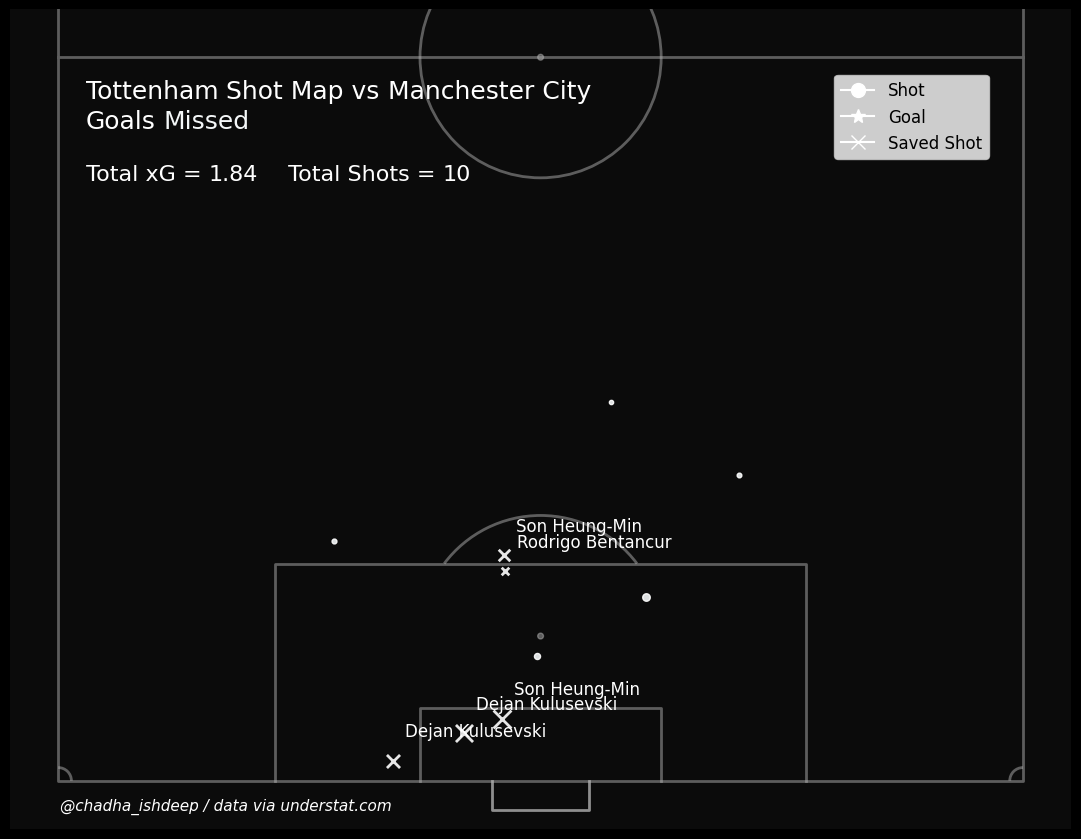

In [28]:
pitch = VerticalPitch(pitch_type='statsbomb',half=True,
                 line_alpha=0.5, goal_alpha=0.8,corner_arcs=True,goal_type='box')

fig, ax = pitch.draw(figsize=(13,8.5))
fig.set_facecolor('black')
ax.patch.set_facecolor('#0B0B0B')
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()

#plt.ylim(0,60)
hteam = 'Tottenham'
ateam = 'Manchester City'
#hteam_facecolor = '#2CAEEA'
#ateam_facecolor = '#fbbc0d'

plotShotMap(hteam,hteam_facecolor,annotate=True)

s1 = '<{}> Shot Map vs <{}> \n<Goals> <Missed>'
highlight_text.fig_text(
                x=.15,y=.9,
                s = s1.format(hteam,ateam),
                #highlight_weights=['bold'],
                #string_weight='bold',
                fontsize=18,
                #fontname='Roboto',
                color=text_color,
                #highlight_colors=['#74c69d','#ff4d4d'],
                highlight_textprops=[{"color" : 'white'},{"color" : 'white'},{"color": hteam_facecolor},{"color": '#F4F7F8'}],
                ax = ax)

s2 = ' Total xG = <{}>'
highlight_text.fig_text(
               x=.145,y=.8,
               s = s2.format(hlast),
               #highlight_weights=['bold'],
               #string_weight='bold',
               fontsize=16,
               #fontfamily='Andale Mono',
               color=text_color,
               #highlight_colors = [text_color]
               highlight_textprops=[{"color": text_color}],
               ax = ax)

s3 = ' Total Shots = <{}>'
highlight_text.fig_text(
               x=.3,y=.8,
               s = s3.format(hteam_total_shots),
               #highlight_weights=['bold'],
               #string_weight='bold',
               fontsize=16,
               #fontfamily='Andale Mono',
               color=text_color,
               #highlight_colors = [text_color]
               highlight_textprops=[{"color": text_color}],
               ax = ax)

fig.text(.13,.04,"@chadha_ishdeep / data via understat.com",fontstyle='italic',fontsize=11,color=text_color)
# Define custom legend entries
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markersize=10, label='Shot'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=hteam_facecolor, markersize=10, label='Goal'),
    Line2D([0], [0], marker='x', color=hteam_facecolor, markerfacecolor=hteam_facecolor, markersize=10, label='Saved Shot')
]

# Add legend
ax.legend(handles=legend_elements,  bbox_to_anchor=(0.93, 0.93), fontsize=12)

plt.savefig('C:/Users/acer/Desktop/IndianCityzen/Projects/MatchReports/CityAway/14-05-2024/Spursshotmap.png',dpi=300,bbox_inches = 'tight',facecolor=background)

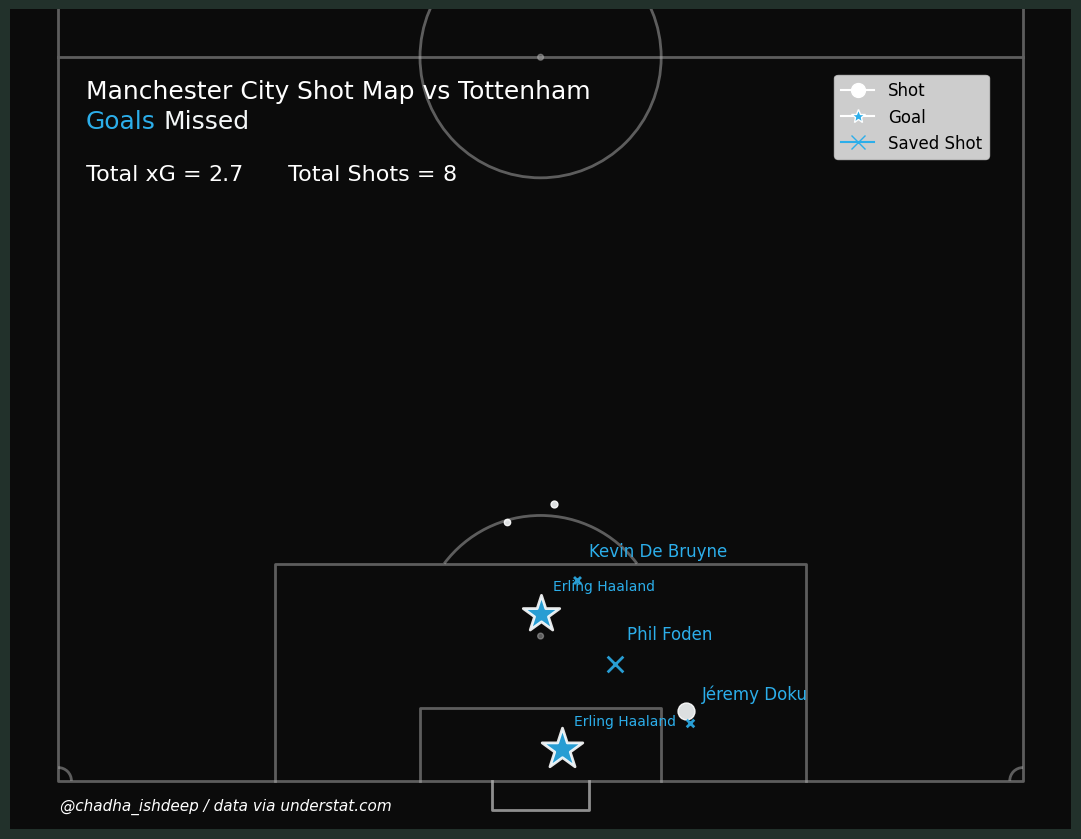

In [27]:
pitch = VerticalPitch(pitch_type='statsbomb',half=True,
                 line_alpha=0.5, goal_alpha=0.8,corner_arcs=True,goal_type='box')

fig, ax = pitch.draw(figsize=(13,8.5))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#0B0B0B')
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()

#plt.ylim(0,60)
hteam = 'Tottenham'
ateam = 'Manchester City'
#hteam_facecolor = '#2CAEEA'
#ateam_facecolor = '#fbbc0d'
plotShotMap(ateam,ateam_facecolor,annotate=True)

s1 = '<{}> Shot Map vs <{}> \n<Goals> <Missed>'
highlight_text.fig_text(
                x=.15,y=.9,
                s = s1.format(ateam,hteam),
                #highlight_weights=['bold'],
                #string_weight='bold',
                fontsize=18,
                #fontname='Roboto',
                color=text_color,
                #highlight_colors=['#74c69d','#ff4d4d'],
                highlight_textprops=[{"color" : 'white'},{"color" : 'white'},{"color": ateam_facecolor},{"color": '#F4F7F8'}],
                ax = ax)

s2 = ' Total xG = <{}>'
highlight_text.fig_text(
               x=.145,y=.8,
               s = s2.format(alast),
               #highlight_weights=['bold'],
               #string_weight='bold',
               fontsize=16,
               #fontfamily='Andale Mono',
               color=text_color,
               #highlight_colors = [text_color]
               highlight_textprops=[{"color": text_color}],
               ax = ax)

s3 = ' Total Shots = <{}>'
highlight_text.fig_text(
               x=.3,y=.8,
               s = s3.format(ateam_total_shots),
               #highlight_weights=['bold'],
               #string_weight='bold',
               fontsize=16,
               #fontfamily='Andale Mono',
               color=text_color,
               #highlight_colors = [text_color]
               highlight_textprops=[{"color": text_color}],
               ax = ax)

fig.text(.13,.04,"@chadha_ishdeep / data via understat.com",fontstyle='italic',fontsize=11,color=text_color)


# Define custom legend entries
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markersize=10, label='Shot'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=ateam_facecolor, markersize=10, label='Goal'),
    Line2D([0], [0], marker='x', color=ateam_facecolor, markerfacecolor=ateam_facecolor, markersize=10, label='Saved Shot')
]

# Add legend
ax.legend(handles=legend_elements,  bbox_to_anchor=(0.93, 0.93), fontsize=12)

plt.savefig('C:/Users/acer/Desktop/IndianCityzen/Projects/MatchReports/CityAway/14-05-2024/Cityshotmap.png',dpi=300,bbox_inches = 'tight',facecolor=background)

In [29]:
df

,x,y,xG,result,team,player,minute,situation,player_assisted,xx,yy
0,37.039999,102.600000,0.099819,SavedShot,Tottenham,Rodrigo Bentancur,5,OpenPlay,Brennan Johnson,46.299999,85.500000
1,39.679999,109.680002,0.038258,MissedShots,Tottenham,Cristian Romero,17,FromCorner,James Maddison,49.599998,91.400002
2,48.720001,104.760004,0.058516,MissedShots,Tottenham,Son Heung-Min,33,FromCorner,None,60.900002,87.300003
3,36.800000,114.839996,0.552482,SavedShot,Tottenham,Son Heung-Min,48,OpenPlay,Brennan Johnson,46.000000,95.699997
4,56.479999,94.680002,0.022760,BlockedShot,Tottenham,Son Heung-Min,50,OpenPlay,James Maddison,70.599998,78.900002
5,33.679999,116.039996,0.503269,SavedShot,Tottenham,Dejan Kulusevski,70,OpenPlay,None,42.099998,96.699997
6,22.880000,100.080002,0.024381,MissedShots,Tottenham,Dejan Kulusevski,77,FromCorner,James Maddison,28.600000,83.400002
7,27.760001,118.319998,0.295161,SavedShot,Tottenham,Dejan Kulusevski,79,OpenPlay,None,34.700001,98.599998
8,45.839999,88.560004,0.018895,BlockedShot,Tottenham,Pape Sarr,80,OpenPlay,James Maddison,57.299999,73.800003
9,36.960001,101.280002,0.229305,SavedShot,Tottenham,Son Heung-Min,85,OpenPlay,Brennan Johnson,46.200001,84.400002


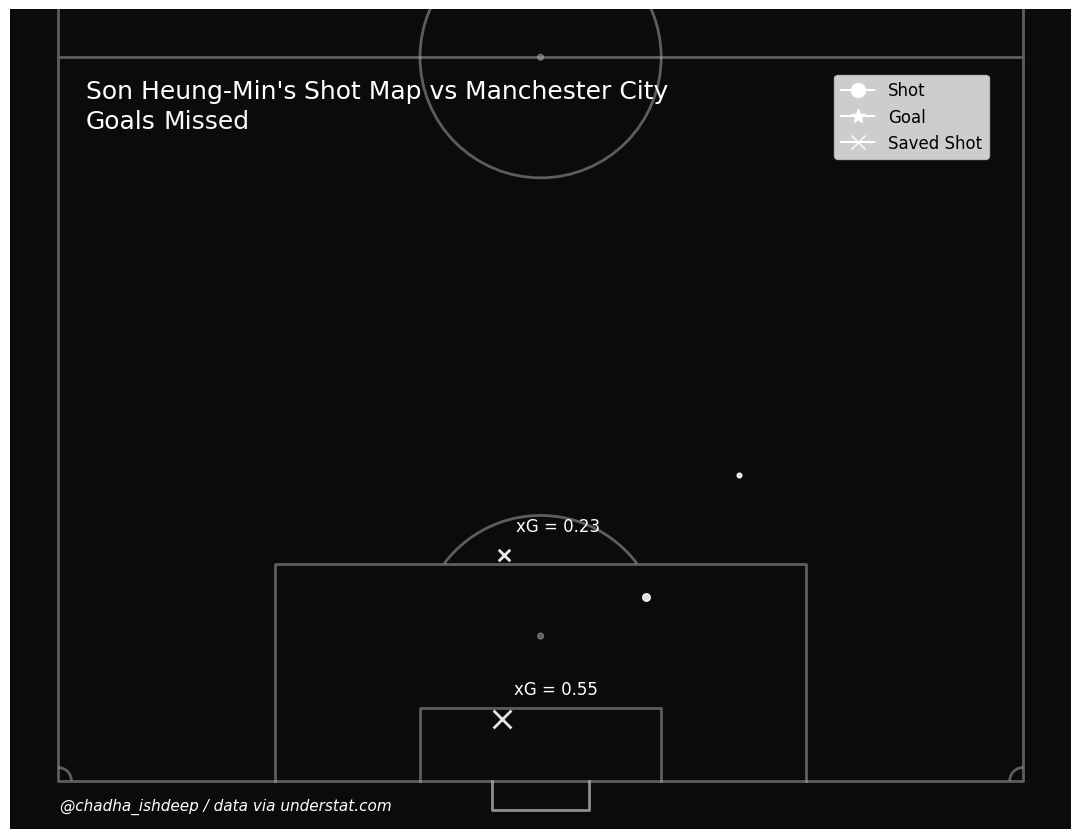

In [35]:
pitch = VerticalPitch(pitch_type='statsbomb',half=True,
                 line_alpha=0.5, goal_alpha=0.8,corner_arcs=True,goal_type='box')

fig, ax = pitch.draw(figsize=(13,8.5))
fig.set_facecolor('#ffffff')
ax.patch.set_facecolor('#0B0B0B')
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()

#plt.ylim(0,60)
player = "Son Heung-Min's"
plotShotMap_player(hteam,'#ffffff','Son Heung-Min',annotate=True)

s1 = '<{}> Shot Map vs <{}> \n<Goals> <Missed>'
highlight_text.fig_text(
                x=.15,y=.9,
                s = s1.format(player,ateam),
                #highlight_weights=['bold'],
                #string_weight='bold',
                fontsize=18,
                #fontname='Roboto',
                color=text_color,
                #highlight_colors=['#74c69d','#ff4d4d'],
                highlight_textprops=[{"color" : 'white'},{"color" : 'white'},{"color": '#ffffff'},{"color": '#F4F7F8'}],
                ax = ax)

fig.text(.13,.04,"@chadha_ishdeep / data via understat.com",fontstyle='italic',fontsize=11,color=text_color)
# Define custom legend entries
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markersize=10, label='Shot'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='white', markersize=10, label='Goal'),
    Line2D([0], [0], marker='x', color='w', markerfacecolor='white', markersize=10, label='Saved Shot')
]

# Add legend
ax.legend(handles=legend_elements,  bbox_to_anchor=(0.93, 0.93), fontsize=12)

plt.savefig('C:/Users/acer/Desktop/IndianCityzen/Projects/MatchReports/CityAway/14-05-2024/Sonoshotmap.png',dpi=300,bbox_inches = 'tight',facecolor=background)

## Using Soccerdata lib to extract data from WhoScored.com

In [45]:
ws = sd.WhoScored(leagues="ENG-Premier League", seasons="2023/2024")
#print(ws.__doc__)

[05/15/24 13:54:13] INFO     Saving cached data to C:\Users\acer\soccerdata\data\WhoScored            ]8;id=950306;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=992854;file://C:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_common.py#91\91]8;;\

In [50]:
df_whoscored = ws.read_events(match_id=1729441)

TimeoutException: Message: 
Stacktrace:
	GetHandleVerifier [0x00CEC113+48259]
	(No symbol) [0x00C7CA41]
	(No symbol) [0x00B70A17]
	(No symbol) [0x00BB0BED]
	(No symbol) [0x00BB0C9B]
	(No symbol) [0x00BEBC12]
	(No symbol) [0x00BD0DE4]
	(No symbol) [0x00BE9B9C]
	(No symbol) [0x00BD0B36]
	(No symbol) [0x00BA570D]
	(No symbol) [0x00BA62CD]
	GetHandleVerifier [0x00FA65A3+2908435]
	GetHandleVerifier [0x00FE3BBB+3159851]
	GetHandleVerifier [0x00D850CB+674875]
	GetHandleVerifier [0x00D8B28C+699900]
	(No symbol) [0x00C86244]
	(No symbol) [0x00C82298]
	(No symbol) [0x00C8242C]
	(No symbol) [0x00C74BB0]
	BaseThreadInitThunk [0x77106839+25]
	RtlGetFullPathName_UEx [0x77CB906F+1215]
	RtlGetFullPathName_UEx [0x77CB903D+1165]


In [41]:
df_whoscored['player'].unique

NameError: name 'df_whoscored' is not defined

## Creating PassMap for Specific Player from the Match

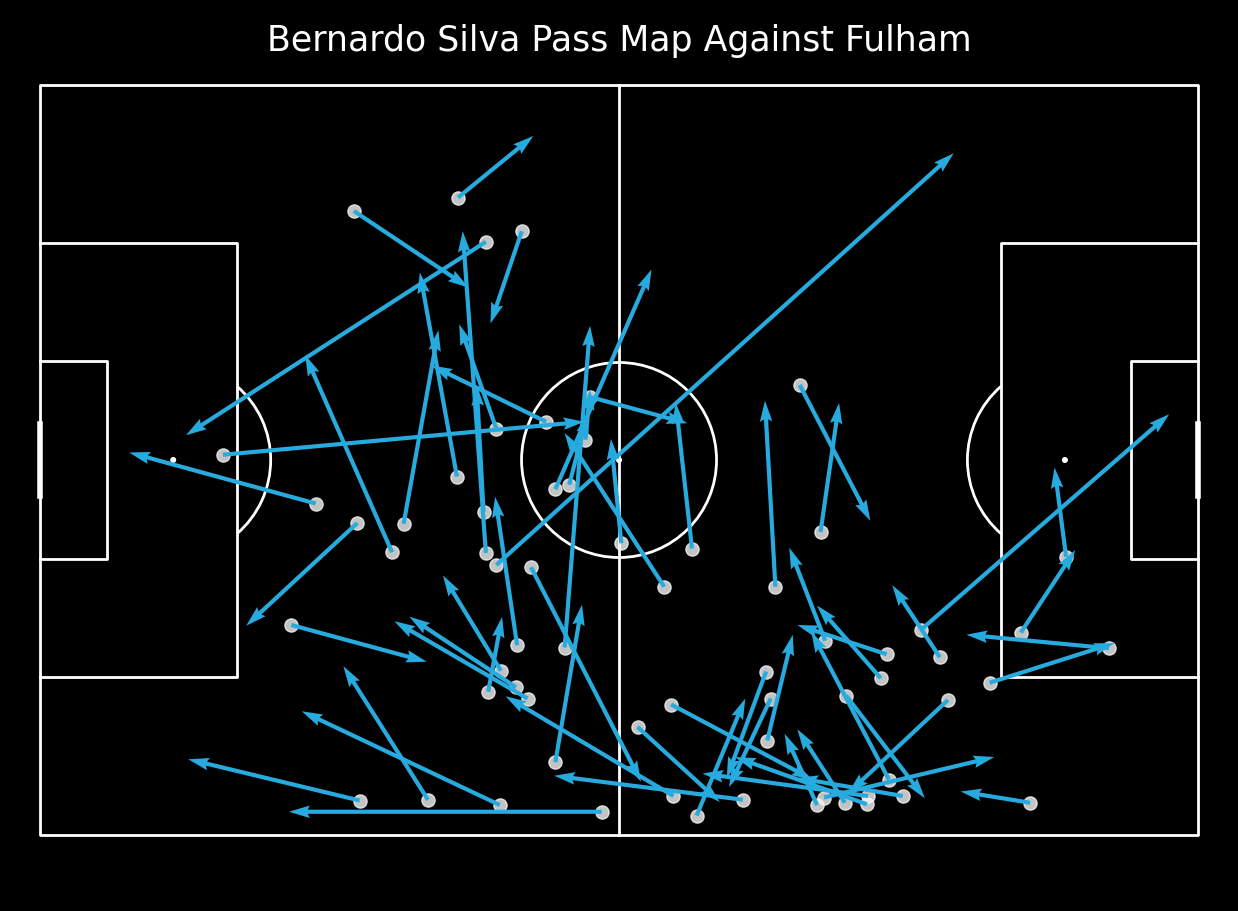

In [39]:
df_whoscored.reset_index(inplace=True)
df_whoscored.rename(columns={'index': 'id'}, inplace=True)
df_whoscored['id'] += 1

player = 'Bernardo Silva'
df_player = df_whoscored.loc[df_whoscored['player'] == player]

selected_col = ['period', 'minute', 'second','x', 'y','end_x', 'end_y','outcome_type']
player_passes_df = df_player.loc[(df_player['type'] == 'Pass') & (df_player['outcome_type'] == 'Successful'), selected_col]

pitch = Pitch(pitch_type='opta',pitch_color='black', line_color='white',
              pad_top=4)  # optional stripes
fig, ax = pitch.grid(grid_height=0.9, title_height=0.05, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)


fig.set_facecolor('black')

pitch.scatter(player_passes_df.x, player_passes_df.y, alpha = 0.8, s = 90, color = "#F6F5F5", ax=ax['pitch'])
pitch.arrows(player_passes_df.x, player_passes_df.y,player_passes_df.end_x, player_passes_df.end_y, color = "#27ABDE", ax=ax['pitch'],width=3)

        
fig.suptitle(f"{player} Pass Map Against Fulham", fontsize = 25,color='white')
plt.savefig('C:/Users/acer/Desktop/IndianCityzen/Projects/MatchReports/CityAway/11-05-2024/Joskopassmap.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## Plot for Danger Passes (Passes within 15 seconds of a shot) by the Team

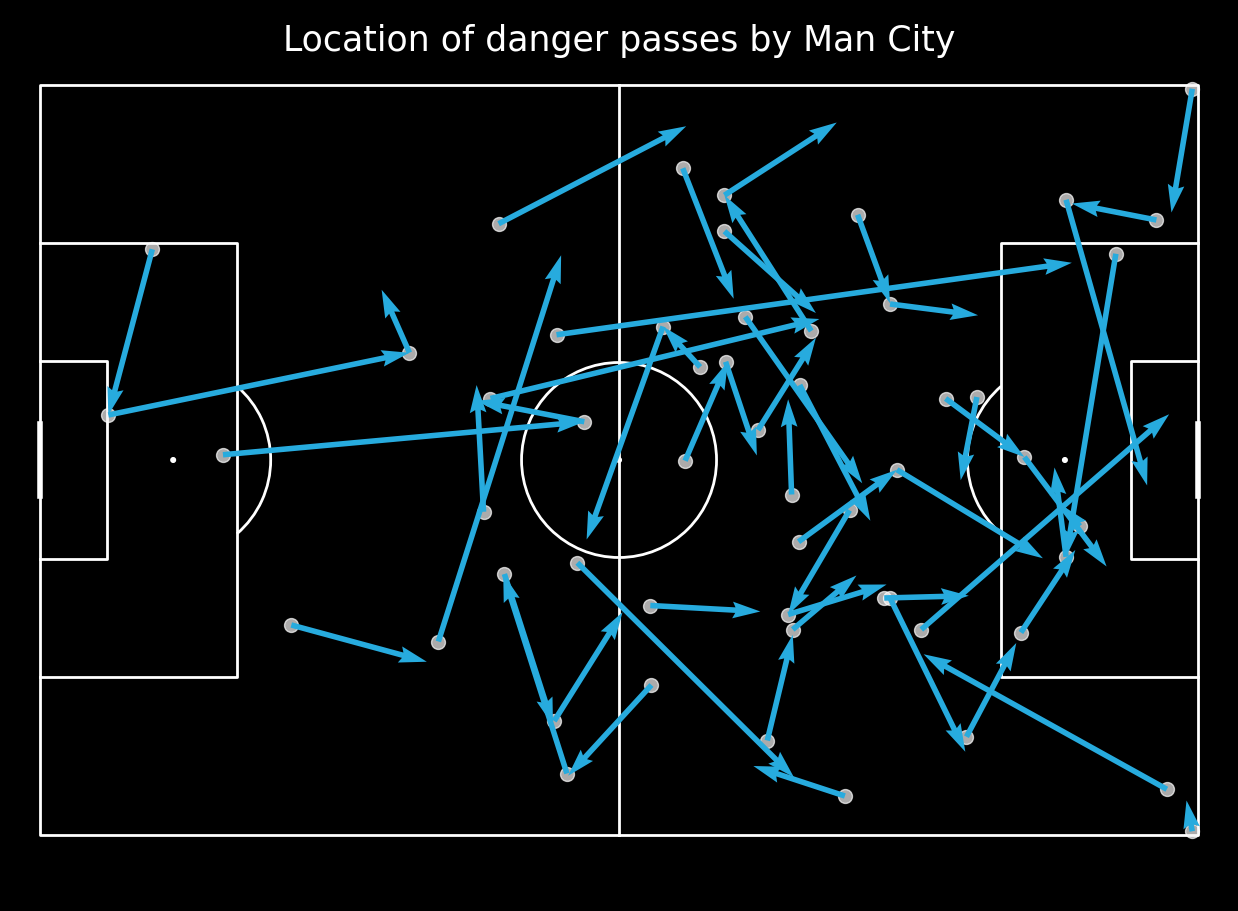

In [46]:
# Assuming the column containing the string values is named 'half'
df_whoscored['period'] = df_whoscored['period'].replace({'FirstHalf': 1, 'SecondHalf': 2})

danger_passes = pd.DataFrame()
team = 'Man City'
for period in [1, 2]:
    #keep only accurate passes by KDB that were not set pieces in this period
    mask_pass = (df_whoscored.team == team) & (df_whoscored.type == "Pass") & (df_whoscored.outcome_type == 'Successful') & (df_whoscored.period == period)
    #keep only necessary columns
    passes = df_whoscored.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second"]]
    #keep only Shots by Man City in this period
    mask_shot = (df_whoscored.team == team) & (df_whoscored.type.isin(["Goal", "MissedShots", "SavedShot"])) & (df_whoscored.period == period)
    #keep only necessary columns
    shots = df_whoscored.loc[mask_shot, ["minute", "second"]]
    #convert time to seconds
    shot_times = shots['minute']*60+shots['second']
    shot_window = 15
    #find starts of the window
    shot_start = shot_times - shot_window
    #condition to avoid negative shot starts
    shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
    #convert to seconds
    pass_times = passes['minute']*60+passes['second']
    #check if pass is in any of the windows for this half
    pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

    #keep only danger passes
    danger_passes_period = passes.loc[pass_to_shot]
    #concatenate dataframe with a previous one to keep danger passes from the whole tournament
    danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)


#plot pitch
pitch = Pitch(pitch_type='opta',pitch_color='black', line_color='white',
              pad_top=4)  # optional stripes
fig, ax = pitch.grid(grid_height=0.9, title_height=0.05, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)


fig.set_facecolor('black')
#scatter the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='#F6F5F5', edgecolors='white', linewidth=1, alpha=0.7, ax=ax["pitch"])
#uncomment it to plot arrows
pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "#27ABDE", ax=ax['pitch'])
#add title
fig.suptitle('Location of danger passes by ' + team, fontsize = 25,color='white')
#plt.show()
plt.savefig('C:/Users/acer/Desktop/IndianCityzen/Projects/MatchReports/CityAway/11-05-2024/DangerPasses.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## Creating Passing Network for a Team

First Subsitutuion By Man City was made in minute : 21


C:\Users\acer\AppData\Local\Temp\ipykernel_7432\2812648921.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_firsthalf['pass_recepient'] = None
C:\Users\acer\AppData\Local\Temp\ipykernel_7432\2812648921.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_secondhalf['pass_recepient'] = None


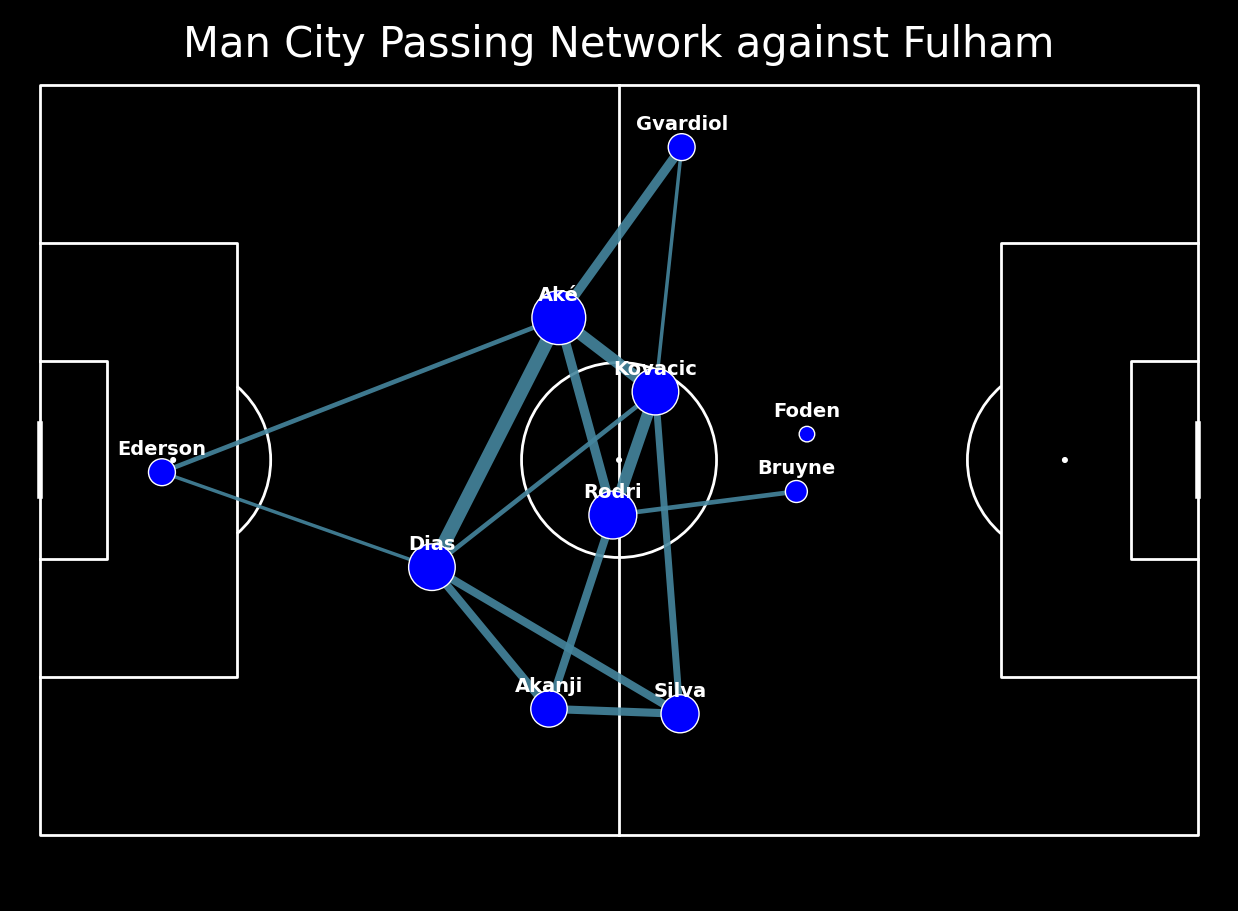

In [42]:
first_sub_min = df_whoscored.loc[df_whoscored['type']=='SubstitutionOff'].loc[df_whoscored['team']=='Man City'].iloc[0]['minute']
print(f"First Subsitutuion By Man City was made in minute : {first_sub_min}")
first_sub_sec = df_whoscored.loc[df_whoscored['type']=='SubstitutionOff'].loc[df_whoscored['team']=='Man City'].iloc[0]['second']

mask_passes = (df_whoscored.type == 'Pass') & (df_whoscored.period == 1) & (df_whoscored.outcome_type == 'Successful')
passes_firsthalf = df_whoscored.loc[mask_passes]
passes_firsthalf.reset_index(inplace=True)
#passes_firsthalf.head()
passes_firsthalf['pass_recepient'] = None

# Check if DataFrame is not empty
if not passes_firsthalf.empty:
    # Loop until the second to last index
    for i in range(len(passes_firsthalf) - 1):
        if passes_firsthalf.team.iloc[i] == passes_firsthalf.team.iloc[i+1]:
            passes_firsthalf.at[i, 'pass_recepient'] = passes_firsthalf.at[i+1, 'player']

mask_passes = (df_whoscored.type == 'Pass') & (df_whoscored.period == 2) & (df_whoscored.outcome_type == 'Successful')
passes_secondhalf = df_whoscored.loc[mask_passes]
passes_secondhalf.reset_index(inplace=True)
#passes_firsthalf.head()
passes_secondhalf['pass_recepient'] = None

# Check if DataFrame is not empty
if not passes_secondhalf.empty:
    # Loop until the second to last index
    for i in range(len(passes_secondhalf) - 1):
        if passes_secondhalf.team.iloc[i] == passes_secondhalf.team.iloc[i+1]:
            passes_secondhalf.at[i, 'pass_recepient'] = passes_secondhalf.at[i+1, 'player']

df_whoscored_pass = pd.concat([passes_firsthalf,passes_secondhalf], ignore_index=True)
#make df_whoscored with successfull passes by England until the first substitution
mask_city = (df_whoscored_pass.team == "Man City") & (df_whoscored_pass.minute < first_sub_min)
#taking necessary columns
df_whoscored_pass = df_whoscored_pass.loc[mask_city, ['x', 'y', 'end_x', 'end_y', "player", "pass_recepient"]]
df_whoscored_pass["player"] = df_whoscored_pass["player"].apply(lambda x: str(x).split()[-1])
df_whoscored_pass["pass_recepient"] = df_whoscored_pass["pass_recepient"].apply(lambda x: str(x).split()[-1])
df_whoscored_pass.reset_index(inplace=True)

df_whoscored_pass = df_whoscored_pass[df_whoscored_pass['pass_recepient'] != 'None']

scatter_df_whoscored = pd.DataFrame()
for i, name in enumerate(df_whoscored_pass["player"].unique()):
    passx = df_whoscored_pass.loc[df_whoscored_pass["player"] == name]["x"].to_numpy()
    recx = df_whoscored_pass.loc[df_whoscored_pass["pass_recepient"] == name]["end_x"].to_numpy()
    passy = df_whoscored_pass.loc[df_whoscored_pass["player"] == name]["y"].to_numpy()
    recy = df_whoscored_pass.loc[df_whoscored_pass["pass_recepient"] == name]["end_y"].to_numpy()
    scatter_df_whoscored.at[i, "player"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df_whoscored.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df_whoscored.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df_whoscored.at[i, "no"] = df_whoscored_pass.loc[df_whoscored_pass["player"] == name].count().iloc[0]

#adjust the size of a circle so that the player who made more passes
scatter_df_whoscored['marker_size'] = (scatter_df_whoscored['no'] / scatter_df_whoscored['no'].max() * 1500)

#counting passes between players
df_whoscored_pass["pair_key"] = df_whoscored_pass.apply(lambda x: "_".join(sorted([x["player"], x["pass_recepient"]])), axis=1)
lines_df_whoscored = df_whoscored_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df_whoscored.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df_whoscored = lines_df_whoscored[lines_df_whoscored['pass_count']>2]

#plot once again pitch and vertices
pitch = Pitch(pitch_type='opta',pitch_color='black', line_color='white',
              pad_top=4)  # optional stripes
fig, ax = pitch.grid(grid_height=0.9, title_height=0.05, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)


fig.set_facecolor('black')
pitch.scatter(scatter_df_whoscored.x, scatter_df_whoscored.y, s=scatter_df_whoscored.marker_size, color='blue', edgecolors='white', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df_whoscored.iterrows():
    pitch.annotate(row.player, xy=(row.x, row.y+3), c='white', va='center', ha='center', weight = "bold", size=14, ax=ax["pitch"], zorder = 4)

for i, row in lines_df_whoscored.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player1]['x'].iloc[0]
        player1_y = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player1]['y'].iloc[0]
        player2_x = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player2]['x'].iloc[0]
        player2_y = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player2]['y'].iloc[0]
        #print(scatter_df_whoscored.index)
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df_whoscored['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=0.9, lw=line_width, zorder=2, color="#45869E", ax = ax["pitch"])

fig.suptitle("Man City Passing Network against Fulham", fontsize = 30,color='white')
plt.savefig('C:/Users/acer/Desktop/IndianCityzen/Projects/MatchReports/CityAway/11-05-2024/PassingNetwork.png',dpi=500,bbox_inches = 'tight',facecolor=background)

First Subsitutuion By Wolves was made in minute : 45


C:\Users\acer\AppData\Local\Temp\ipykernel_7432\2065013019.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_firsthalf['pass_recepient'] = None
C:\Users\acer\AppData\Local\Temp\ipykernel_7432\2065013019.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_secondhalf['pass_recepient'] = None


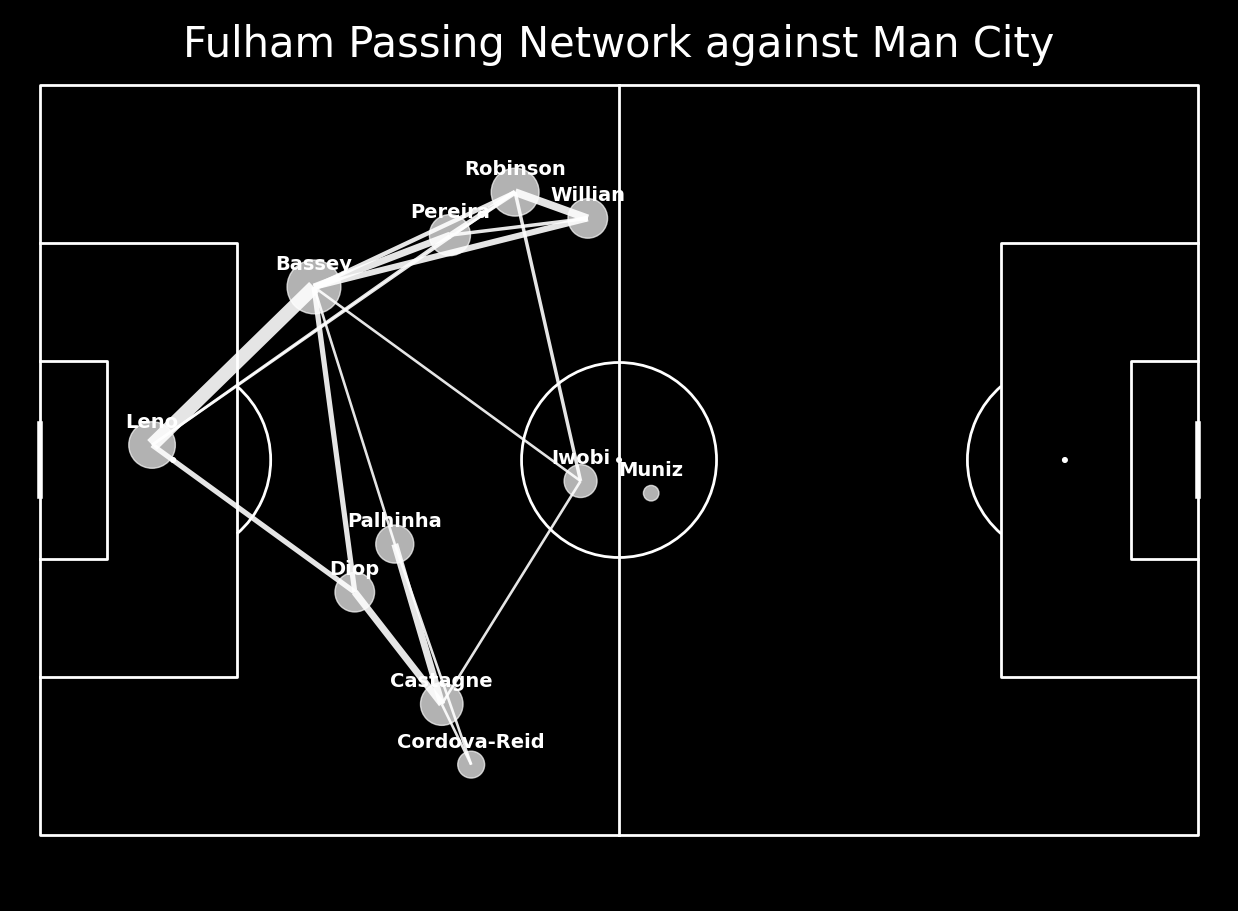

In [44]:
first_sub_min = df_whoscored.loc[df_whoscored['type']=='SubstitutionOff'].loc[df_whoscored['team']=='Fulham'].iloc[0]['minute']
print(f"First Subsitutuion By Wolves was made in minute : {first_sub_min}")
first_sub_sec = df_whoscored.loc[df_whoscored['type']=='SubstitutionOff'].loc[df_whoscored['team']=='Fulham'].iloc[0]['second']

mask_passes = (df_whoscored.type == 'Pass') & (df_whoscored.period == 1) & (df_whoscored.outcome_type == 'Successful')
passes_firsthalf = df_whoscored.loc[mask_passes]
passes_firsthalf.reset_index(inplace=True)
#passes_firsthalf.head()
passes_firsthalf['pass_recepient'] = None

# Check if DataFrame is not empty
if not passes_firsthalf.empty:
    # Loop until the second to last index
    for i in range(len(passes_firsthalf) - 1):
        if passes_firsthalf.team.iloc[i] == passes_firsthalf.team.iloc[i+1]:
            passes_firsthalf.at[i, 'pass_recepient'] = passes_firsthalf.at[i+1, 'player']

mask_passes = (df_whoscored.type == 'Pass') & (df_whoscored.period == 2) & (df_whoscored.outcome_type == 'Successful')
passes_secondhalf = df_whoscored.loc[mask_passes]
passes_secondhalf.reset_index(inplace=True)
#passes_firsthalf.head()
passes_secondhalf['pass_recepient'] = None

# Check if DataFrame is not empty
if not passes_secondhalf.empty:
    # Loop until the second to last index
    for i in range(len(passes_secondhalf) - 1):
        if passes_secondhalf.team.iloc[i] == passes_secondhalf.team.iloc[i+1]:
            passes_secondhalf.at[i, 'pass_recepient'] = passes_secondhalf.at[i+1, 'player']

df_whoscored_pass = pd.concat([passes_firsthalf,passes_secondhalf], ignore_index=True)
#make df_whoscored with successfull passes by England until the first substitution
mask_city = (df_whoscored_pass.team == "Fulham") & (df_whoscored_pass.minute < first_sub_min)
#taking necessary columns
df_whoscored_pass = df_whoscored_pass.loc[mask_city, ['x', 'y', 'end_x', 'end_y', "player", "pass_recepient"]]
df_whoscored_pass["player"] = df_whoscored_pass["player"].apply(lambda x: str(x).split()[-1])
df_whoscored_pass["pass_recepient"] = df_whoscored_pass["pass_recepient"].apply(lambda x: str(x).split()[-1])
df_whoscored_pass.reset_index(inplace=True)

df_whoscored_pass = df_whoscored_pass[df_whoscored_pass['pass_recepient'] != 'None']

scatter_df_whoscored = pd.DataFrame()
for i, name in enumerate(df_whoscored_pass["player"].unique()):
    passx = df_whoscored_pass.loc[df_whoscored_pass["player"] == name]["x"].to_numpy()
    recx = df_whoscored_pass.loc[df_whoscored_pass["pass_recepient"] == name]["end_x"].to_numpy()
    passy = df_whoscored_pass.loc[df_whoscored_pass["player"] == name]["y"].to_numpy()
    recy = df_whoscored_pass.loc[df_whoscored_pass["pass_recepient"] == name]["end_y"].to_numpy()
    scatter_df_whoscored.at[i, "player"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df_whoscored.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df_whoscored.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df_whoscored.at[i, "no"] = df_whoscored_pass.loc[df_whoscored_pass["player"] == name].count().iloc[0]

#adjust the size of a circle so that the player who made more passes
scatter_df_whoscored['marker_size'] = (scatter_df_whoscored['no'] / scatter_df_whoscored['no'].max() * 1500)

#counting passes between players
df_whoscored_pass["pair_key"] = df_whoscored_pass.apply(lambda x: "_".join(sorted([x["player"], x["pass_recepient"]])), axis=1)
lines_df_whoscored = df_whoscored_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df_whoscored.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df_whoscored = lines_df_whoscored[lines_df_whoscored['pass_count']>2]

#plot once again pitch and vertices
pitch = Pitch(pitch_type='opta',pitch_color='black', line_color='white',
              pad_top=4)  # optional stripes
fig, ax = pitch.grid(grid_height=0.9, title_height=0.05, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)


fig.set_facecolor('black')
pitch.scatter(scatter_df_whoscored.x, scatter_df_whoscored.y, s=scatter_df_whoscored.marker_size, color='#ffffff', edgecolors='white', linewidth=1, alpha=0.7, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df_whoscored.iterrows():
    pitch.annotate(row.player, xy=(row.x, row.y+3), c='white', va='center', ha='center', weight = "bold", size=14, ax=ax["pitch"], zorder = 4)

for i, row in lines_df_whoscored.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player1]['x'].iloc[0]
        player1_y = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player1]['y'].iloc[0]
        player2_x = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player2]['x'].iloc[0]
        player2_y = scatter_df_whoscored.loc[scatter_df_whoscored["player"] == player2]['y'].iloc[0]
        #print(scatter_df_whoscored.index)
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df_whoscored['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=0.9, lw=line_width, zorder=2, color="#ffffff", ax = ax["pitch"])

fig.suptitle("Fulham Passing Network against Man City", fontsize = 30,color='white')
plt.savefig('C:/Users/acer/Desktop/IndianCityzen/Projects/MatchReports/CityAway/11-05-2024/PassingNetworkF.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## Another Way of Creating a Passing Network with html file

In [136]:
import re
import json
def extract_json_from_html(html_path, save_output=False):
    #html_file = open(html_path, 'r')
    #html = html_file.read()
    #html_file.close()
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [137]:
html_path = './ManCity-Madrid.html'
json_data_txt = extract_json_from_html(html_path)

In [138]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df_whoscored = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df_whoscored["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df_whoscored = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df_whoscored["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df_whoscored = pd.concat([players_home_df_whoscored, players_away_df_whoscored])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df_whoscored, teams_dict

In [139]:
data = json.loads(json_data_txt)
events_dict, players_df_whoscored, teams_dict = extract_data_from_dict(data)

In [140]:
def get_passes_df_whoscored(events_dict):
    df_whoscored = pd.DataFrame(events_dict)
    df_whoscored['eventType'] = df_whoscored.apply(lambda row: row['type']['displayName'], axis=1)
    df_whoscored['outcomeType'] = df_whoscored.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df_whoscored["receiver"] = df_whoscored["playerId"].shift(-1)

    # filter only passes
    passes_ids = df_whoscored.index[df_whoscored['eventType'] == 'Pass']
    df_whoscored_passes = df_whoscored.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_whoscored_passes

In [141]:
passes_df_whoscored = get_passes_df_whoscored(events_dict)

In [142]:
def get_passes_between_df_whoscored(team_id, passes_df_whoscored, players_df_whoscored):
    # filter for only team
    passes_df_whoscored = passes_df_whoscored[passes_df_whoscored["teamId"] == team_id]

    # add column with first eleven players only
    passes_df_whoscored = passes_df_whoscored.merge(players_df_whoscored[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df_whoscored = passes_df_whoscored[passes_df_whoscored['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df_whoscored = (passes_df_whoscored.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df_whoscored.columns = ['x', 'y', 'count']
    average_locs_and_count_df_whoscored = average_locs_and_count_df_whoscored.merge(players_df_whoscored[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df_whoscored = average_locs_and_count_df_whoscored.set_index('playerId')

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df_whoscored = passes_df_whoscored.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df_whoscored['pos_max'] = (passes_player_ids_df_whoscored[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df_whoscored['pos_min'] = (passes_player_ids_df_whoscored[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df_whoscored = passes_player_ids_df_whoscored.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df_whoscored.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df_whoscored = passes_between_df_whoscored.merge(average_locs_and_count_df_whoscored, left_on='pos_min', right_index=True)
    passes_between_df_whoscored = passes_between_df_whoscored.merge(average_locs_and_count_df_whoscored, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df_whoscored, average_locs_and_count_df_whoscored

In [143]:
home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df_whoscored, home_average_locs_and_count_df_whoscored = get_passes_between_df_whoscored(home_team_id, passes_df_whoscored, players_df_whoscored)

away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df_whoscored, away_average_locs_and_count_df_whoscored = get_passes_between_df_whoscored(away_team_id, passes_df_whoscored, players_df_whoscored)

In [145]:
def pass_network_visualization(ax, passes_between_df_whoscored, average_locs_and_count_df_whoscored, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 3000
    passes_between_df_whoscored['width'] = (passes_between_df_whoscored.pass_count / passes_between_df_whoscored.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df_whoscored['marker_size'] = (average_locs_and_count_df_whoscored['count']
                                                / average_locs_and_count_df_whoscored['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df_whoscored), 1))
    c_transparency = passes_between_df_whoscored.pass_count / passes_between_df_whoscored.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#0D182E', line_color='#5B6378')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df_whoscored['x'] = pitch.dim.right - passes_between_df_whoscored['x']
        passes_between_df_whoscored['y'] = pitch.dim.right - passes_between_df_whoscored['y']
        passes_between_df_whoscored['x_end'] = pitch.dim.right - passes_between_df_whoscored['x_end']
        passes_between_df_whoscored['y_end'] = pitch.dim.right - passes_between_df_whoscored['y_end']
        average_locs_and_count_df_whoscored['x'] = pitch.dim.right - average_locs_and_count_df_whoscored['x']
        average_locs_and_count_df_whoscored['y'] = pitch.dim.right - average_locs_and_count_df_whoscored['y']

    pass_lines = pitch.lines(passes_between_df_whoscored.x, passes_between_df_whoscored.y,
                             passes_between_df_whoscored.x_end, passes_between_df_whoscored.y_end, lw=passes_between_df_whoscored.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df_whoscored.x, average_locs_and_count_df_whoscored.y,
                               s=average_locs_and_count_df_whoscored.marker_size, marker='h',
                               color='#FEFEFC', edgecolors='#FEFEFC', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df_whoscored.iterrows():
        player_name = row["name"].split()
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='#C4C4C4', va='center',
                       ha='center', size=14, ax=ax)

    return pitch

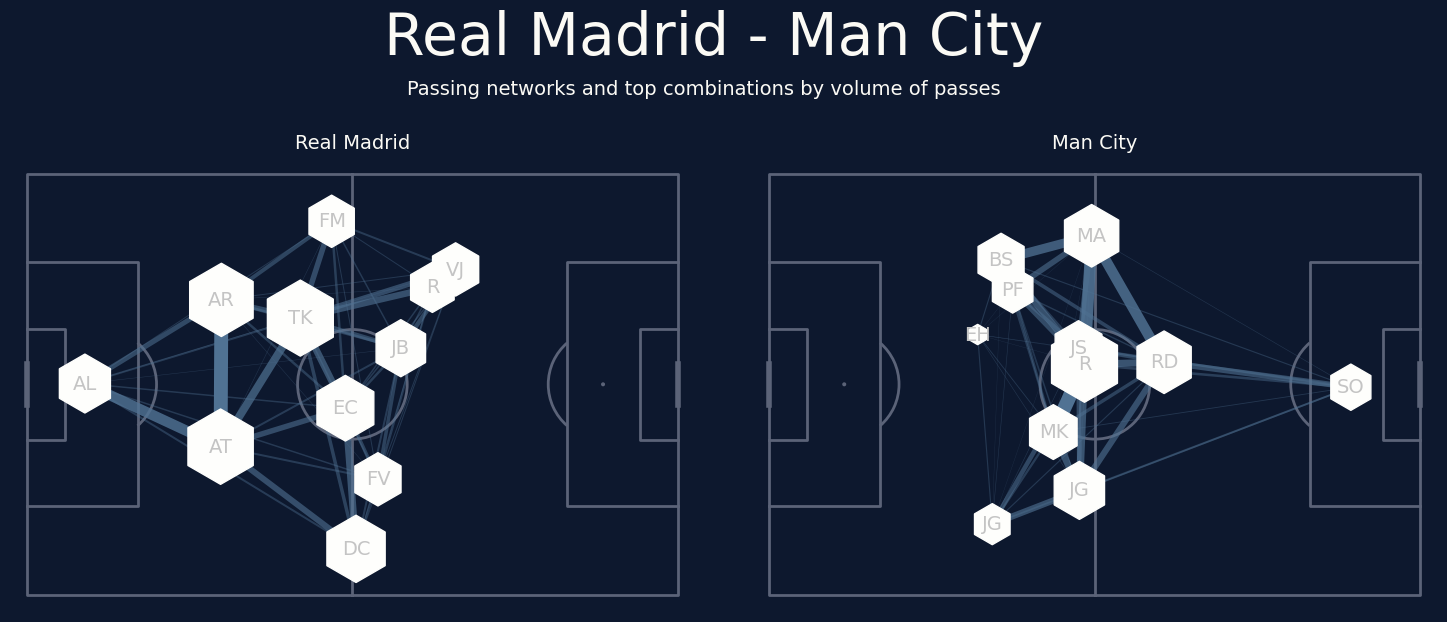

In [146]:
# create plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()
fig.set_facecolor("#0D182E")

# plot variables
main_color = '#FBFAF5'
#font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         #"RobotoCondensed-Medium.ttf?raw=true"))

# home team viz
pass_network_visualization(axes[0], home_passes_between_df_whoscored, home_average_locs_and_count_df_whoscored)
axes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df_whoscored, away_average_locs_and_count_df_whoscored, flipped=True)
axes[1].set_title(teams_dict[away_team_id], color=main_color, fontsize=14)

plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=42)
subtitle = "Passing networks and top combinations by volume of passes"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14)
plt.savefig('output.png', bbox_inches='tight')
plt.show()